In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import os
import json
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from datetime import datetime
import platform
import psutil
import os
import sys
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [2]:
# Export class labels to a JSON file
def export_class_labels_json(label_map: Dict[str, int], filepath: str) -> None:
    """
    Exports the class label mapping (from label to numeric encoding) to a JSON file.
    """
    with open(filepath, 'w') as f:
        json.dump(label_map, f, indent=2)
    print(f"Class labels exported to {filepath}")

In [3]:
# Balance the dataset for testing purposes
def balance_classes_equal_samples(features: np.ndarray, labels: np.ndarray, n_samples_per_class: int = 20) -> Tuple[np.ndarray, np.ndarray]:
    """
    Balances the dataset by downsampling each class to have an equal number of samples (n_samples_per_class),
    and shuffles the resulting dataset.
    """
    unique_labels = np.unique(labels)
    balanced_features = []
    balanced_labels = []
    
    for label in unique_labels:
        # Get all the indices for the current label
        class_indices = np.where(labels == label)[0]
        
        # Downsample to have n_samples_per_class for each class
        sampled_indices = resample(class_indices, n_samples=n_samples_per_class, random_state=42)
        
        balanced_features.append(features[sampled_indices])
        balanced_labels.append(labels[sampled_indices])
    
    # Concatenate all the balanced data
    balanced_features = np.vstack(balanced_features)
    balanced_labels = np.concatenate(balanced_labels)
    
    # Shuffle the dataset
    shuffle_indices = np.random.permutation(balanced_features.shape[0])
    balanced_features = balanced_features[shuffle_indices]
    balanced_labels = balanced_labels[shuffle_indices]
    
    return balanced_features, balanced_labels

In [4]:
# Read CSV to NDArray

def read_csv_to_ndarray(file_path: str) -> Tuple[np.ndarray, List[str], List[str]]:
    """
    Reads a CSV file and converts it to a NumPy array for features and a list for labels.
    """
    df = pd.read_csv(file_path)
    if df.empty:
        raise ValueError("CSV file is empty or data is invalid")
    
    feature_names = df.columns[:-1].tolist()
    features = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].astype(str).tolist()
    return features, labels, feature_names

In [5]:
# Select top N features based on importance

def select_top_features(features: np.ndarray, labels: np.ndarray, feature_names: List[str], n_features: int = 10) -> Tuple[np.ndarray, List[str], List[int]]:
    """
    Selects top N features based on importance scores using actual labels.
    """
    # Train a preliminary model with actual labels to get feature importance
    prelim_model = DecisionTreeClassifier(max_depth=10, random_state=42)
    prelim_model.fit(features, labels)
    
    # Get indices of top N features
    importances = prelim_model.feature_importances_
    top_indices = np.argsort(importances)[::-1][:n_features]
    
    # Select top features and their names
    selected_features = features[:, top_indices]
    selected_names = [feature_names[i] for i in top_indices]
    
    print("\nTop 10 features selected:")
    for idx, (name, importance) in enumerate(zip(selected_names, importances[top_indices]), 1):
        print(f"{idx}. {name} (importance: {importance:.4f})")
    
    return selected_features, selected_names, top_indices.tolist()

In [6]:
# Create feature mapping
def create_feature_mapping(file_paths: List[str], selected_indices: List[int]) -> Dict[str, Dict[int, str]]:
    """
    Creates a mapping of feature indices to their names for each file.
    """
    feature_mapping = {}
    
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        _, _, feature_names = read_csv_to_ndarray(file_path)
        
        file_mapping = {idx: feature_names[original_idx] 
                       for idx, original_idx in enumerate(selected_indices)}
        feature_mapping[file_name] = file_mapping
    
    return feature_mapping

In [7]:
# Export feature mapping to JSON
def export_feature_mapping(mapping: Dict[str, Dict[int, str]], filepath: str) -> None:
    """
    Exports the feature mapping to a JSON file.
    """
    with open(filepath, 'w') as f:
        json.dump(mapping, f, indent=2)
    print(f"Feature mapping exported to {filepath}")

In [8]:
# Encode labels to numeric values
def encode_labels(labels: List[str]) -> Tuple[np.ndarray, Dict[str, int]]:
    """
    Encodes string labels into numeric values.
    """
    unique_labels = sorted(set(labels))
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    encoded_labels = np.array([label_map[label] for label in labels])
    return encoded_labels, label_map

In [9]:
def add_rows_with_smote(features: np.ndarray, labels: np.ndarray, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Adds a specific number of synthetic samples to a dataset using SMOTE.
    """
    # Validate input
    if np.isnan(features).any():
        raise ValueError("Input features contain NaN values.")
    if np.isinf(features).any():
        raise ValueError("Input features contain Inf or -Inf values.")

    # Get current class distribution
    unique_labels, class_counts = np.unique(labels, return_counts=True)
    n_classes = len(unique_labels)
    
    # Calculate how many samples to add per class (distribute evenly)
    samples_per_class = n_samples // n_classes
    remainder = n_samples % n_classes
    
    # Create sampling strategy dictionary
    sampling_strategy = {}
    for i, label in enumerate(unique_labels):
        extra = 1 if i < remainder else 0
        target_count = class_counts[i] + samples_per_class + extra
        sampling_strategy[label] = target_count
    
    # Apply SMOTE with the custom sampling strategy
    smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
    X_resampled, y_resampled = smote.fit_resample(features, labels)
    
    print(f"Added {X_resampled.shape[0] - features.shape[0]} synthetic samples using SMOTE")
    print(f"Original shape: {features.shape}, New shape: {X_resampled.shape}")
    
    print("\nClass Distribution - Before:")
    for label, count in zip(unique_labels, class_counts):
        print(f"Class {label}: {count} samples")
    
    new_unique, new_counts = np.unique(y_resampled, return_counts=True)
    print("\nClass Distribution - After:")
    for label, count in zip(new_unique, new_counts):
        print(f"Class {label}: {count} samples")
    
    return X_resampled, y_resampled


In [10]:
def clean_data(features: np.ndarray) -> np.ndarray:
    """
    Cleans the feature matrix by replacing invalid values with finite values.
    """
    cleaned_features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    return cleaned_features

In [11]:
def split_data(features: np.ndarray, labels: np.ndarray, test_size: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Splits data into training and testing sets.
    """
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
    return x_train, y_train, x_test, y_test


In [12]:
# Read data from csv
file_paths = [
        "./data/1.csv",
        "./data/2.csv",
        "./data/3.csv",
        "./data/4.csv"
    ]
    
all_features = []
all_labels = []
all_feature_names = []

print("Reading data from CSV...")
for file_path in file_paths:
    features, labels, feature_names = read_csv_to_ndarray(file_path)
    all_features.append(features)
    all_labels.extend(labels)
    if not all_feature_names:
        all_feature_names = feature_names

    print("\nCleaning data...")

features = np.vstack(all_features)

features = clean_data(features)

Reading data from CSV...

Cleaning data...

Cleaning data...

Cleaning data...

Cleaning data...


In [13]:
print("Encoding labels...")
encoded_labels, label_map = encode_labels(all_labels)
encoded_labels

Encoding labels...


array([0, 0, 0, ..., 0, 0, 0])

In [14]:
# Create new samples and add them to the dataset
n_samples_to_add = 10000

# Add synthetic samples using SMOTE only for Bot and Infiltration classes
print("\nAdding synthetic samples for Bot and Infiltration classes...")

# 1. Extract only Bot (1) and Infiltration (3) samples
target_classes = [1, 3]  # Bot and Infiltration
target_mask = np.isin(encoded_labels, target_classes)
target_features = features[target_mask]
target_labels = encoded_labels[target_mask]

# 2. Generate synthetic samples for just these classes
synthetic_features, synthetic_labels = add_rows_with_smote(
    target_features, target_labels, n_samples=n_samples_to_add
)

# 3. Get only the newly generated samples
original_count = len(target_labels)
new_samples_features = synthetic_features[original_count:]
new_samples_labels = synthetic_labels[original_count:]

# 4. Add them back to the original dataset
features = np.vstack([features, new_samples_features])
encoded_labels = np.concatenate([encoded_labels, new_samples_labels])


Adding synthetic samples for Bot and Infiltration classes...
Added 10000 synthetic samples using SMOTE
Original shape: (2002, 78), New shape: (12002, 78)

Class Distribution - Before:
Class 1: 1966 samples
Class 3: 36 samples

Class Distribution - After:
Class 1: 6966 samples
Class 3: 5036 samples


In [15]:
# Select top N features based on importance
selected_features, selected_names, selected_indices = select_top_features(
    features, encoded_labels, all_feature_names
)


Top 10 features selected:
1. Total Length of Fwd Packets (importance: 0.3228)
2.  Bwd Packet Length Std (importance: 0.2700)
3. Flow Bytes/s (importance: 0.2567)
4.  Subflow Bwd Packets (importance: 0.0814)
5.  Destination Port (importance: 0.0097)
6. Bwd Packet Length Max (importance: 0.0085)
7.  act_data_pkt_fwd (importance: 0.0075)
8.  Bwd Packets/s (importance: 0.0070)
9. Fwd Packets/s (importance: 0.0050)
10.  Packet Length Mean (importance: 0.0039)


In [16]:
# Create machine learning model

print("\nSplitting data...")
x_train, y_train, x_test, y_test = split_data(selected_features, encoded_labels)
    

model = DecisionTreeClassifier(max_depth=10, random_state=42)
model.fit(x_train, y_train)


Splitting data...


DecisionTreeClassifier(max_depth=10, random_state=42)

Training data sizes (KB): [6574.55859375, 13149.19921875, 19723.83984375, 26298.3984375, 32873.0390625, 39447.6796875, 46022.23828125, 52596.87890625, 59171.51953125, 65746.16015625]
Test data size (KB): 16436.6015625
Training efficiency range: 7742.19 - 16210.25 KB/s


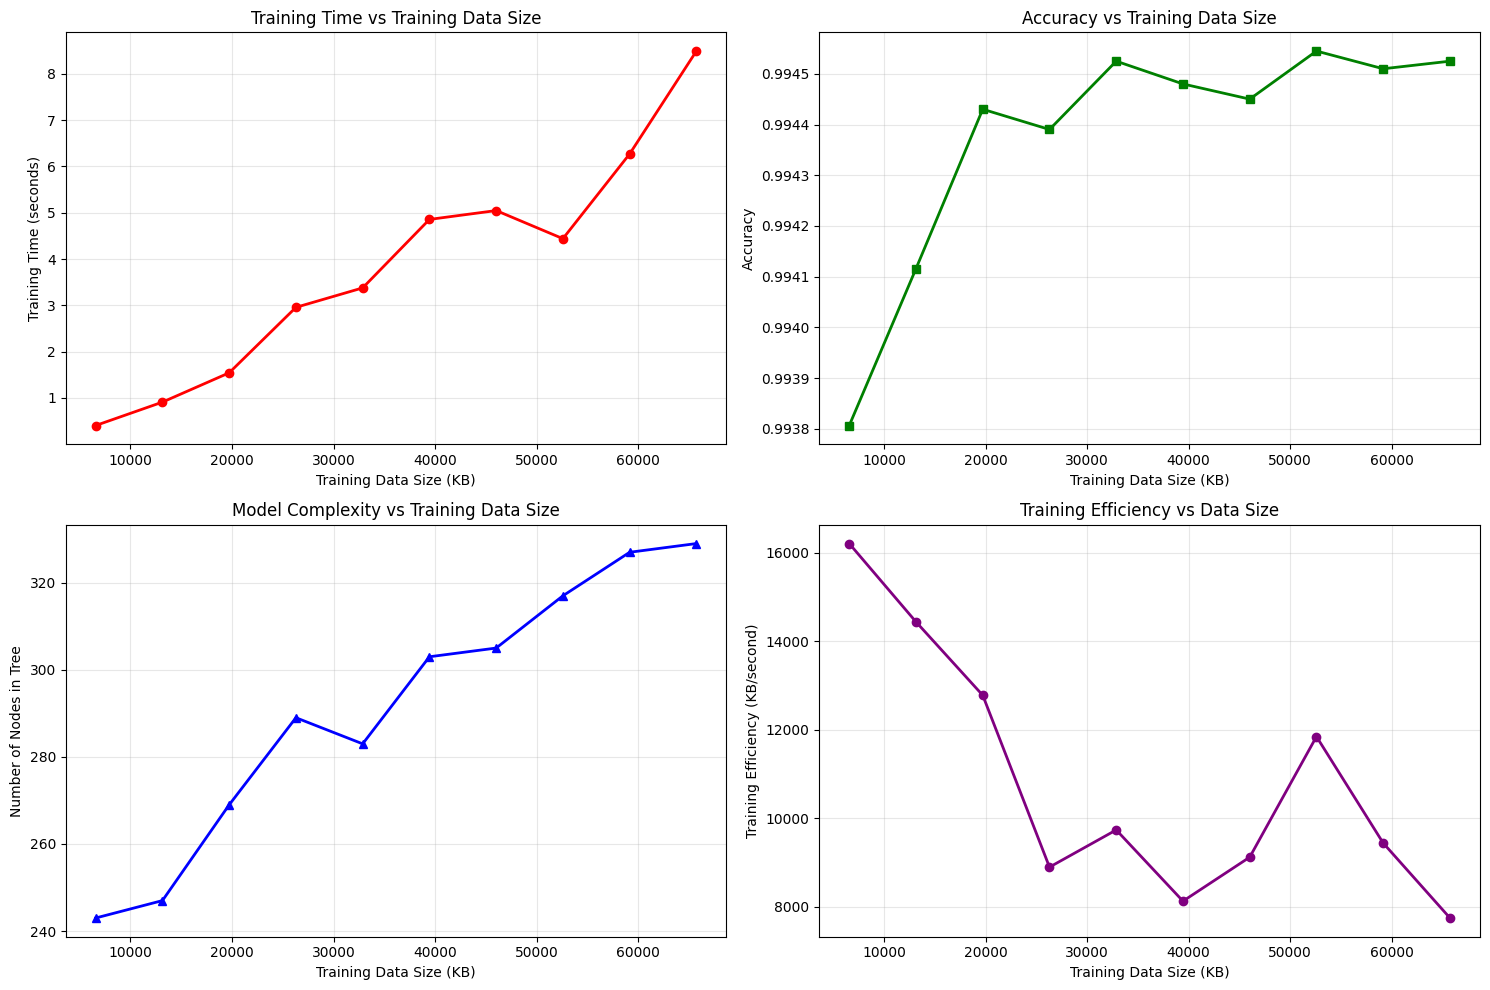


ALTERNATIVE: Throughput vs Test Data Size


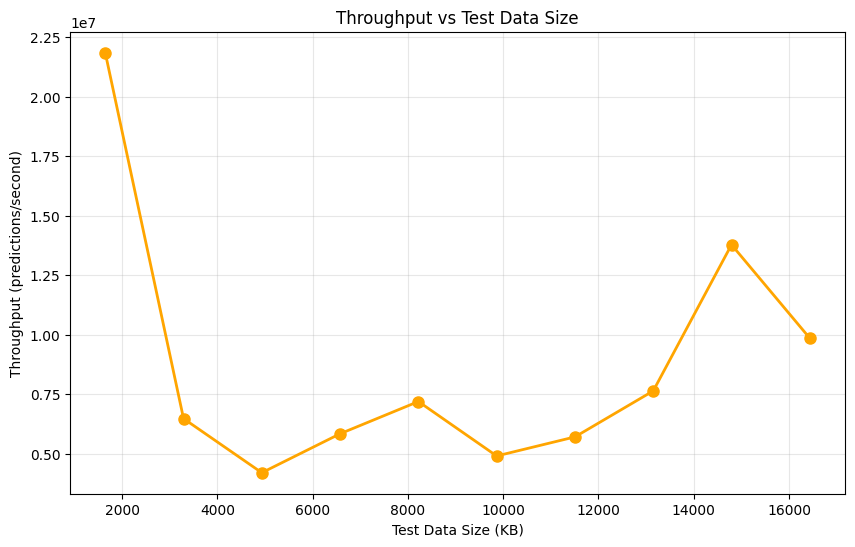

Test data size range: 1643.66 - 16436.60 KB
Throughput range: 4196747.58 - 21851604.07 predictions/s


In [18]:
# Better helper function to get size in KB
def get_size_kb(obj):
    if hasattr(obj, 'nbytes'):  # NumPy arrays
        return obj.nbytes / 1024
    elif hasattr(obj, 'memory_usage'):  # Pandas DataFrames
        return obj.memory_usage(deep=True).sum() / 1024
    else:  # Fallback to sys.getsizeof
        import sys
        return sys.getsizeof(obj) / 1024

# Store metrics
training_data_sizes_kb = []
test_data_sizes_kb = []
training_times = []
accuracies = []
model_complexities = []  # Number of nodes in the tree

# Loop over increasing training data sizes
for i in range(10, 110, 10):  # 10%, 20%, ..., 100%
    slice_size = int(len(x_train) * i / 100)
    x_slice = x_train[:slice_size]
    y_slice = y_train[:slice_size]

    # Measure training time
    train_start = time.time()
    model = DecisionTreeClassifier(max_depth=10, random_state=42)
    model.fit(x_slice, y_slice)
    train_end = time.time()
    training_time = train_end - train_start

    # Measure accuracy
    predictions = model.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)

    # Calculate data sizes
    training_data_size_kb = get_size_kb(x_slice) + get_size_kb(y_slice)
    test_data_size_kb = get_size_kb(x_test) + get_size_kb(y_test)
    
    # Get model complexity (number of nodes)
    model_complexity = model.tree_.node_count

    # Store metrics
    training_data_sizes_kb.append(training_data_size_kb)
    test_data_sizes_kb.append(test_data_size_kb)
    training_times.append(training_time)
    accuracies.append(accuracy)
    model_complexities.append(model_complexity)

training_efficiency = [size / time if time > 0 else 0 for size, time in zip(training_data_sizes_kb, training_times)]
print(f"Training data sizes (KB): {training_data_sizes_kb}")
print(f"Test data size (KB): {test_data_size_kb}")  # Should be constant
print(f"Training efficiency range: {min(training_efficiency):.2f} - {max(training_efficiency):.2f} KB/s")

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Time vs Training Data Size
ax1.plot(training_data_sizes_kb, training_times, 'o-', color='red', linewidth=2, markersize=6)
ax1.set_xlabel("Training Data Size (KB)")
ax1.set_ylabel("Training Time (seconds)")
ax1.set_title("Training Time vs Training Data Size")
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy vs Training Data Size
ax2.plot(training_data_sizes_kb, accuracies, 's-', color='green', linewidth=2, markersize=6)
ax2.set_xlabel("Training Data Size (KB)")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy vs Training Data Size")
ax2.grid(True, alpha=0.3)

# Plot 3: Model Complexity vs Training Data Size
ax3.plot(training_data_sizes_kb, model_complexities, '^-', color='blue', linewidth=2, markersize=6)
ax3.set_xlabel("Training Data Size (KB)")
ax3.set_ylabel("Number of Nodes in Tree")
ax3.set_title("Model Complexity vs Training Data Size")
ax3.grid(True, alpha=0.3)

# Plot 4: Training Efficiency (Data Size vs Training Time)
ax4.plot(training_data_sizes_kb, training_efficiency, 'o-', color='purple', linewidth=2, markersize=6)
ax4.set_xlabel("Training Data Size (KB)")
ax4.set_ylabel("Training Efficiency (KB/second)")
ax4.set_title("Training Efficiency vs Data Size")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Alternative: Throughput vs Test Data Size
# If you want to see how throughput changes with test data size:
print("\n" + "="*50)
print("ALTERNATIVE: Throughput vs Test Data Size")
print("="*50)

test_throughputs = []
test_sizes_kb = []

# Use the full training data for this experiment
model = DecisionTreeClassifier(max_depth=10, random_state=42)
model.fit(x_train, y_train)

# Vary test data size
for i in range(10, 110, 10):
    test_slice_size = int(len(x_test) * i / 100)
    x_test_slice = x_test[:test_slice_size]
    y_test_slice = y_test[:test_slice_size]
    
    # Measure throughput
    start = time.time()
    predictions = model.predict(x_test_slice)
    end = time.time()
    duration = end - start
    throughput = len(x_test_slice) / duration if duration > 0 else 0
    
    test_size_kb = get_size_kb(x_test_slice) + get_size_kb(y_test_slice)
    
    test_throughputs.append(throughput)
    test_sizes_kb.append(test_size_kb)

# Plot throughput vs test data size
plt.figure(figsize=(10, 6))
plt.plot(test_sizes_kb, test_throughputs, 'o-', color='orange', linewidth=2, markersize=8)
plt.xlabel("Test Data Size (KB)")
plt.ylabel("Throughput (predictions/second)")
plt.title("Throughput vs Test Data Size")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Test data size range: {min(test_sizes_kb):.2f} - {max(test_sizes_kb):.2f} KB")
print(f"Throughput range: {min(test_throughputs):.2f} - {max(test_throughputs):.2f} predictions/s")

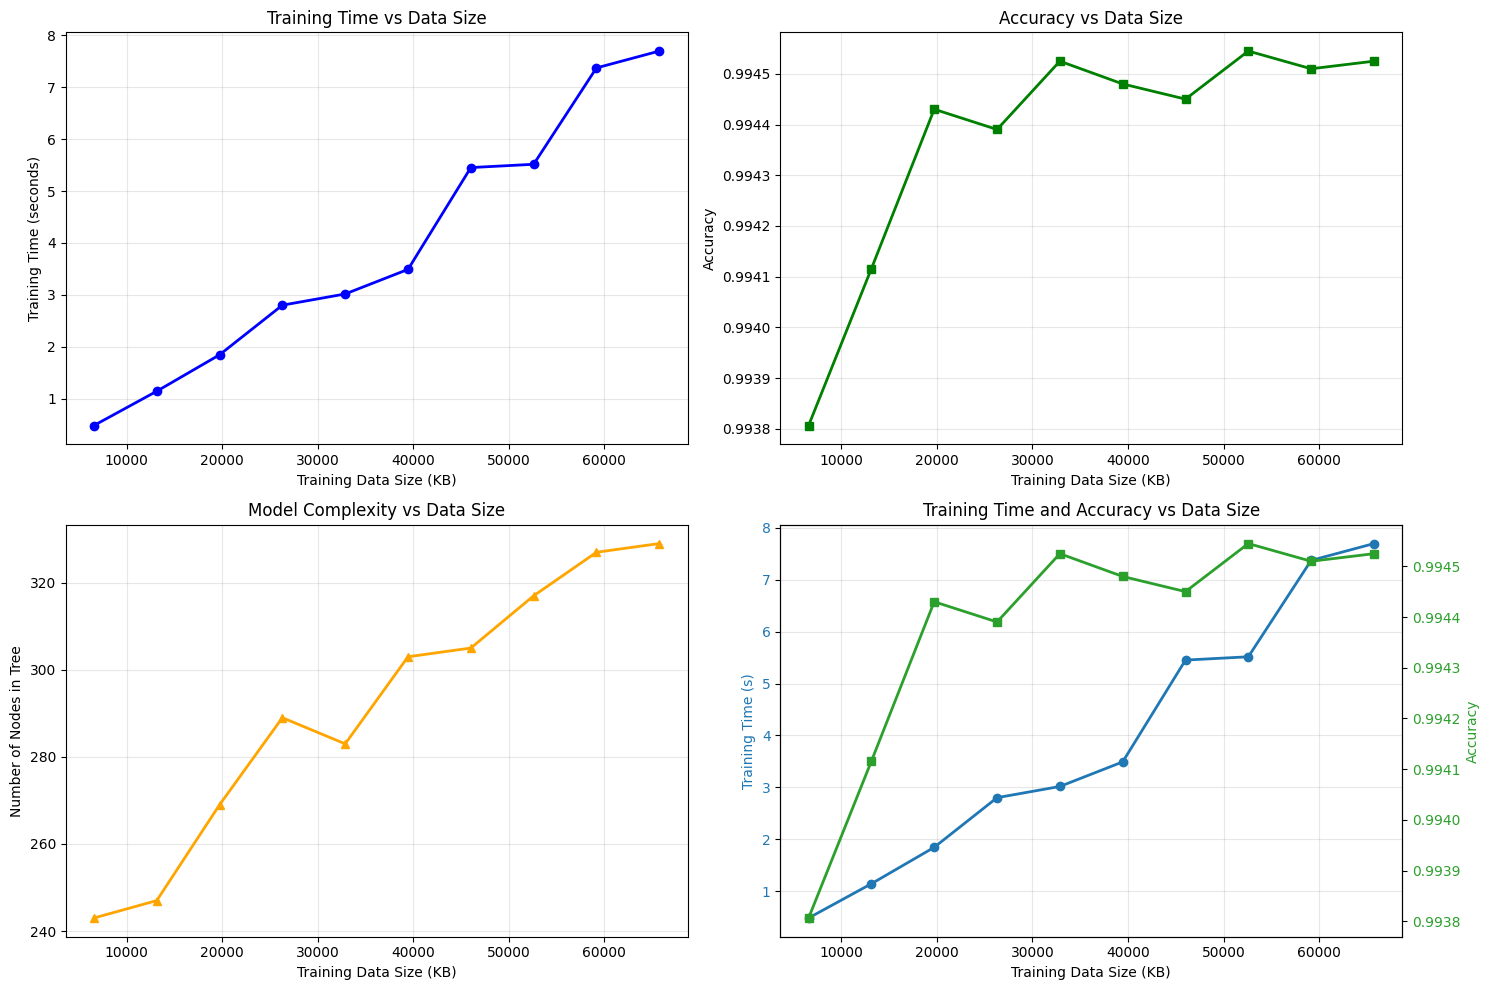

TRAINING ANALYSIS SUMMARY
Data size range: 6574.56 - 65746.16 KB
Training time range: 0.4882 - 7.6927 seconds
Accuracy range: 0.9938 - 0.9945
Model complexity range: 243 - 329 nodes

Correlation with training data size:
Training time: 0.9853
Accuracy: 0.7716
Model complexity: 0.9777


In [19]:
# Store metrics
data_sizes_kb = []
training_times = []
accuracies = []
model_complexities = []  # Number of nodes in the tree

# Loop over increasing percentages of x_train/y_train
for i in range(10, 110, 10):  # 10%, 20%, ..., 100%
    slice_size = int(len(x_train) * i / 100)
    x_slice = x_train[:slice_size]
    y_slice = y_train[:slice_size]

    # Data size in KB (improved calculation)
    data_size_kb = get_size_kb(x_slice) + get_size_kb(y_slice)

    # Training time
    start = time.time()
    t_model = DecisionTreeClassifier(max_depth=10, random_state=42)
    t_model.fit(x_slice, y_slice)
    end = time.time()
    training_time = end - start

    # Accuracy on full test set
    predictions = t_model.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    
    # Model complexity
    model_complexity = t_model.tree_.node_count

    # Store results
    data_sizes_kb.append(data_size_kb)
    training_times.append(training_time)
    accuracies.append(accuracy)
    model_complexities.append(model_complexity)

# Create subplots for comprehensive analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Time vs Data Size
ax1.plot(data_sizes_kb, training_times, 'o-', color='blue', linewidth=2, markersize=6)
ax1.set_xlabel("Training Data Size (KB)")
ax1.set_ylabel("Training Time (seconds)")
ax1.set_title("Training Time vs Data Size")
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy vs Data Size
ax2.plot(data_sizes_kb, accuracies, 's-', color='green', linewidth=2, markersize=6)
ax2.set_xlabel("Training Data Size (KB)")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy vs Data Size")
ax2.grid(True, alpha=0.3)

# Plot 3: Model Complexity vs Data Size
ax3.plot(data_sizes_kb, model_complexities, '^-', color='orange', linewidth=2, markersize=6)
ax3.set_xlabel("Training Data Size (KB)")
ax3.set_ylabel("Number of Nodes in Tree")
ax3.set_title("Model Complexity vs Data Size")
ax3.grid(True, alpha=0.3)

# Plot 4: Training Time and Accuracy vs Data Size (dual axis)
ax4_twin = ax4.twinx()

# Training time
color1 = 'tab:blue'
ax4.set_xlabel('Training Data Size (KB)')
ax4.set_ylabel('Training Time (s)', color=color1)
line1 = ax4.plot(data_sizes_kb, training_times, color=color1, marker='o', 
                 linewidth=2, markersize=6, label='Training Time')
ax4.tick_params(axis='y', labelcolor=color1)

# Accuracy
color2 = 'tab:green'
ax4_twin.set_ylabel('Accuracy', color=color2)
line2 = ax4_twin.plot(data_sizes_kb, accuracies, color=color2, marker='s', 
                      linewidth=2, markersize=6, label='Accuracy')
ax4_twin.tick_params(axis='y', labelcolor=color2)

ax4.set_title("Training Time and Accuracy vs Data Size")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*50)
print("TRAINING ANALYSIS SUMMARY")
print("="*50)
print(f"Data size range: {min(data_sizes_kb):.2f} - {max(data_sizes_kb):.2f} KB")
print(f"Training time range: {min(training_times):.4f} - {max(training_times):.4f} seconds")
print(f"Accuracy range: {min(accuracies):.4f} - {max(accuracies):.4f}")
print(f"Model complexity range: {min(model_complexities)} - {max(model_complexities)} nodes")

# Calculate correlation coefficients
import numpy as np
time_data_corr = np.corrcoef(data_sizes_kb, training_times)[0, 1]
acc_data_corr = np.corrcoef(data_sizes_kb, accuracies)[0, 1]
complexity_data_corr = np.corrcoef(data_sizes_kb, model_complexities)[0, 1]

print(f"\nCorrelation with training data size:")
print(f"Training time: {time_data_corr:.4f}")
print(f"Accuracy: {acc_data_corr:.4f}")
print(f"Model complexity: {complexity_data_corr:.4f}")

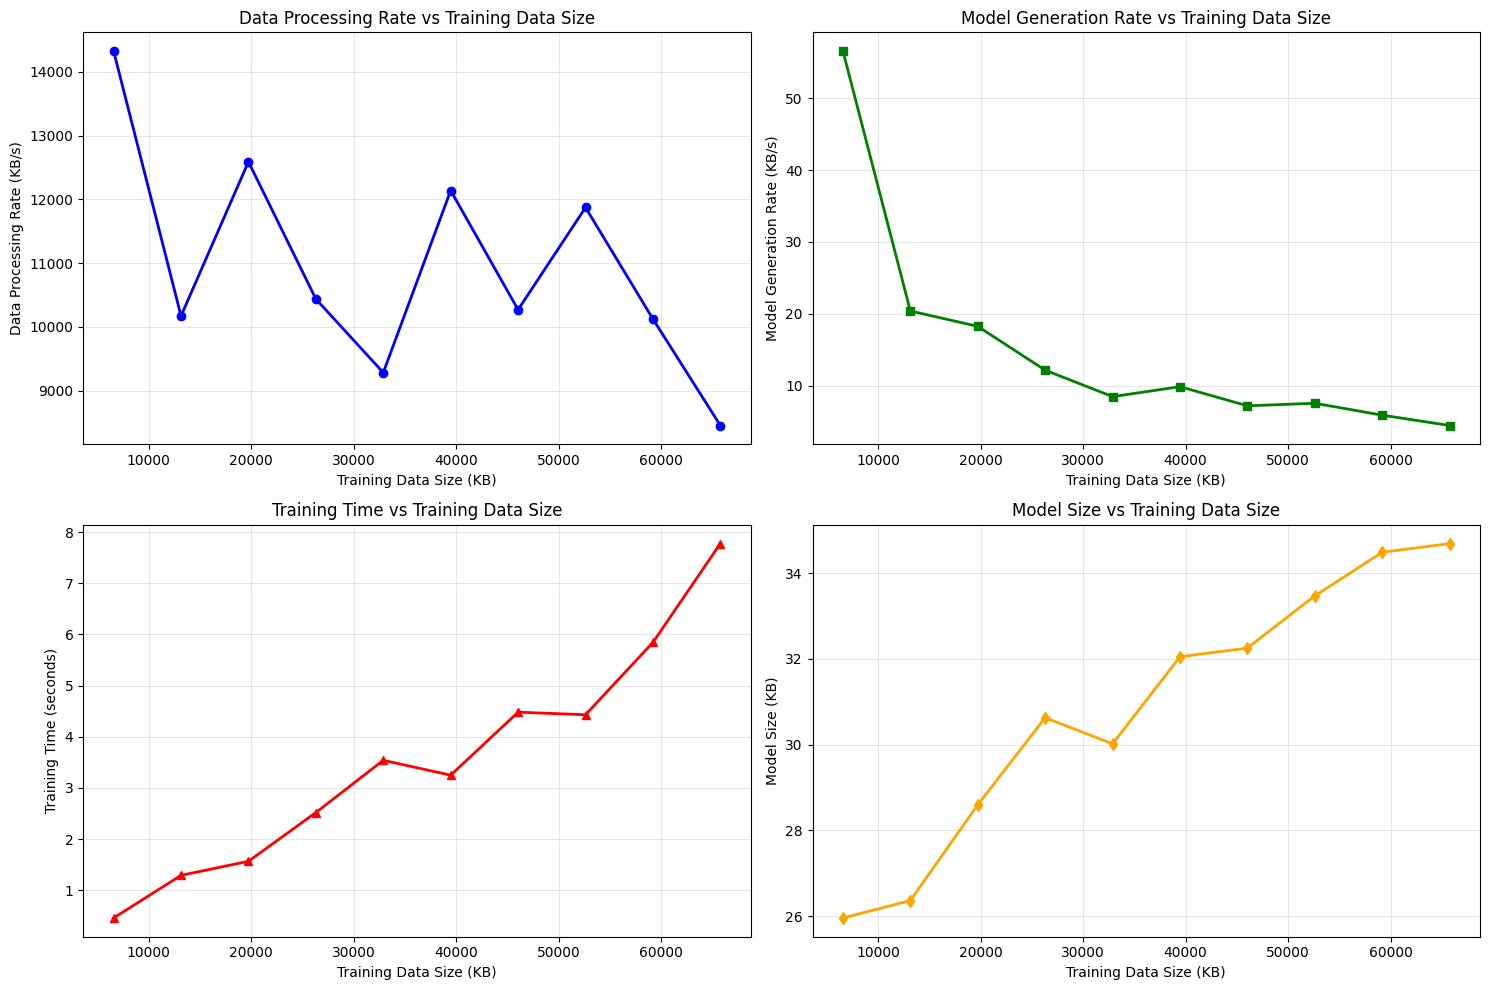

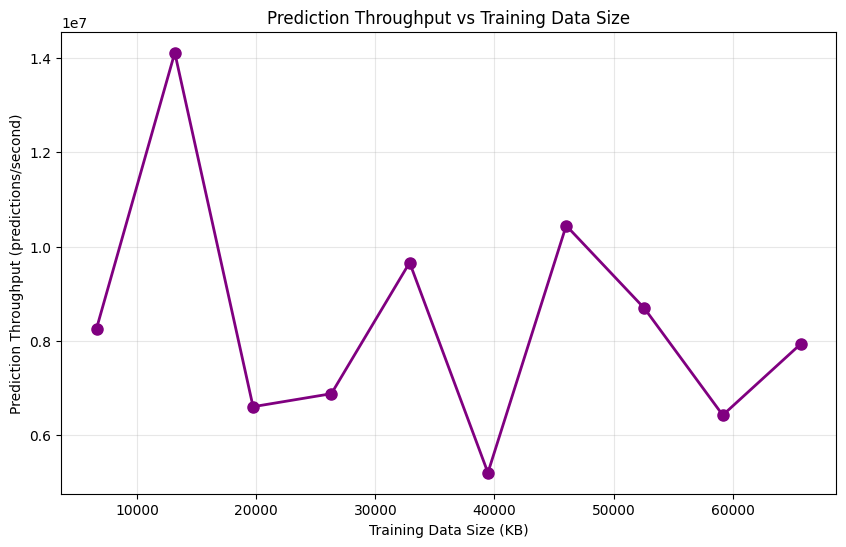

PROCESSING SPEED ANALYSIS SUMMARY
Training data size range: 6574.56 - 65746.16 KB
Training time range: 0.4590 - 7.7754 seconds
Model size range: 25.95 - 34.69 KB
Data processing rate range: 8455.62 - 14324.68 KB/s
Model generation rate range: 4.46 - 56.55 KB/s
Prediction throughput range: 5208115.05 - 14106327.82 predictions/s

Average Performance Metrics:
Data processing rate: 10967.31 KB/s
Model generation rate: 15.08 KB/s
Prediction throughput: 8422793.28 predictions/s

Correlations with training data size:
Data processing rate: -0.5726
Model generation rate: -0.7560
Prediction throughput: -0.2884


In [20]:
# Store metrics
data_sizes_kb = []
training_times = []
model_sizes_kb = []
data_processing_rates = []  # KB of data processed per second
model_generation_rates = []  # KB of model generated per second
prediction_throughputs = []  # Predictions per second

# Loop over increasing slices of the training data
for i in range(10, 110, 10):  # Percent slices: 10%, 20%, ..., 100%
    slice_size = int(len(x_train) * i / 100)
    x_slice = x_train[:slice_size]
    y_slice = y_train[:slice_size]
    
    # Estimate training data size in KB (improved calculation)
    data_size_kb = get_size_kb(x_slice) + get_size_kb(y_slice)

    # Train model and time it
    start = time.time()
    model = DecisionTreeClassifier(max_depth=10, random_state=42)
    model.fit(x_slice, y_slice)
    end = time.time()
    training_time = end - start

    # Save model and get model size
    joblib.dump(model, 'temp_model.joblib')
    model_size_kb = os.path.getsize('temp_model.joblib') / 1024  # in KB

    # Measure prediction throughput
    pred_start = time.time()
    predictions = model.predict(x_test)
    pred_end = time.time()
    pred_time = pred_end - pred_start
    prediction_throughput = len(x_test) / pred_time if pred_time > 0 else 0

    # Compute meaningful processing metrics
    data_processing_rate = data_size_kb / training_time if training_time > 0 else 0
    model_generation_rate = model_size_kb / training_time if training_time > 0 else 0

    # Store results
    data_sizes_kb.append(data_size_kb)
    training_times.append(training_time)
    model_sizes_kb.append(model_size_kb)
    data_processing_rates.append(data_processing_rate)
    model_generation_rates.append(model_generation_rate)
    prediction_throughputs.append(prediction_throughput)

# Clean up temporary file
if os.path.exists('temp_model.joblib'):
    os.remove('temp_model.joblib')

# Create comprehensive analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Data Processing Rate vs Data Size
ax1.plot(data_sizes_kb, data_processing_rates, 'o-', color='blue', linewidth=2, markersize=6)
ax1.set_xlabel("Training Data Size (KB)")
ax1.set_ylabel("Data Processing Rate (KB/s)")
ax1.set_title("Data Processing Rate vs Training Data Size")
ax1.grid(True, alpha=0.3)

# Plot 2: Model Generation Rate vs Data Size
ax2.plot(data_sizes_kb, model_generation_rates, 's-', color='green', linewidth=2, markersize=6)
ax2.set_xlabel("Training Data Size (KB)")
ax2.set_ylabel("Model Generation Rate (KB/s)")
ax2.set_title("Model Generation Rate vs Training Data Size")
ax2.grid(True, alpha=0.3)

# Plot 3: Training Time vs Data Size
ax3.plot(data_sizes_kb, training_times, '^-', color='red', linewidth=2, markersize=6)
ax3.set_xlabel("Training Data Size (KB)")
ax3.set_ylabel("Training Time (seconds)")
ax3.set_title("Training Time vs Training Data Size")
ax3.grid(True, alpha=0.3)

# Plot 4: Model Size vs Data Size
ax4.plot(data_sizes_kb, model_sizes_kb, 'd-', color='orange', linewidth=2, markersize=6)
ax4.set_xlabel("Training Data Size (KB)")
ax4.set_ylabel("Model Size (KB)")
ax4.set_title("Model Size vs Training Data Size")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional plot: Prediction Throughput vs Training Data Size
plt.figure(figsize=(10, 6))
plt.plot(data_sizes_kb, prediction_throughputs, 'o-', color='purple', linewidth=2, markersize=8)
plt.xlabel("Training Data Size (KB)")
plt.ylabel("Prediction Throughput (predictions/second)")
plt.title("Prediction Throughput vs Training Data Size")
plt.grid(True, alpha=0.3)
plt.show()

# Print comprehensive summary
print("="*60)
print("PROCESSING SPEED ANALYSIS SUMMARY")
print("="*60)
print(f"Training data size range: {min(data_sizes_kb):.2f} - {max(data_sizes_kb):.2f} KB")
print(f"Training time range: {min(training_times):.4f} - {max(training_times):.4f} seconds")
print(f"Model size range: {min(model_sizes_kb):.2f} - {max(model_sizes_kb):.2f} KB")
print(f"Data processing rate range: {min(data_processing_rates):.2f} - {max(data_processing_rates):.2f} KB/s")
print(f"Model generation rate range: {min(model_generation_rates):.2f} - {max(model_generation_rates):.2f} KB/s")
print(f"Prediction throughput range: {min(prediction_throughputs):.2f} - {max(prediction_throughputs):.2f} predictions/s")

# Calculate efficiency metrics
avg_data_processing_rate = np.mean(data_processing_rates)
avg_model_generation_rate = np.mean(model_generation_rates)
avg_prediction_throughput = np.mean(prediction_throughputs)

print(f"\nAverage Performance Metrics:")
print(f"Data processing rate: {avg_data_processing_rate:.2f} KB/s")
print(f"Model generation rate: {avg_model_generation_rate:.2f} KB/s")
print(f"Prediction throughput: {avg_prediction_throughput:.2f} predictions/s")

# Calculate correlations
import numpy as np
data_proc_corr = np.corrcoef(data_sizes_kb, data_processing_rates)[0, 1]
model_gen_corr = np.corrcoef(data_sizes_kb, model_generation_rates)[0, 1]
pred_through_corr = np.corrcoef(data_sizes_kb, prediction_throughputs)[0, 1]

print(f"\nCorrelations with training data size:")
print(f"Data processing rate: {data_proc_corr:.4f}")
print(f"Model generation rate: {model_gen_corr:.4f}")
print(f"Prediction throughput: {pred_through_corr:.4f}")

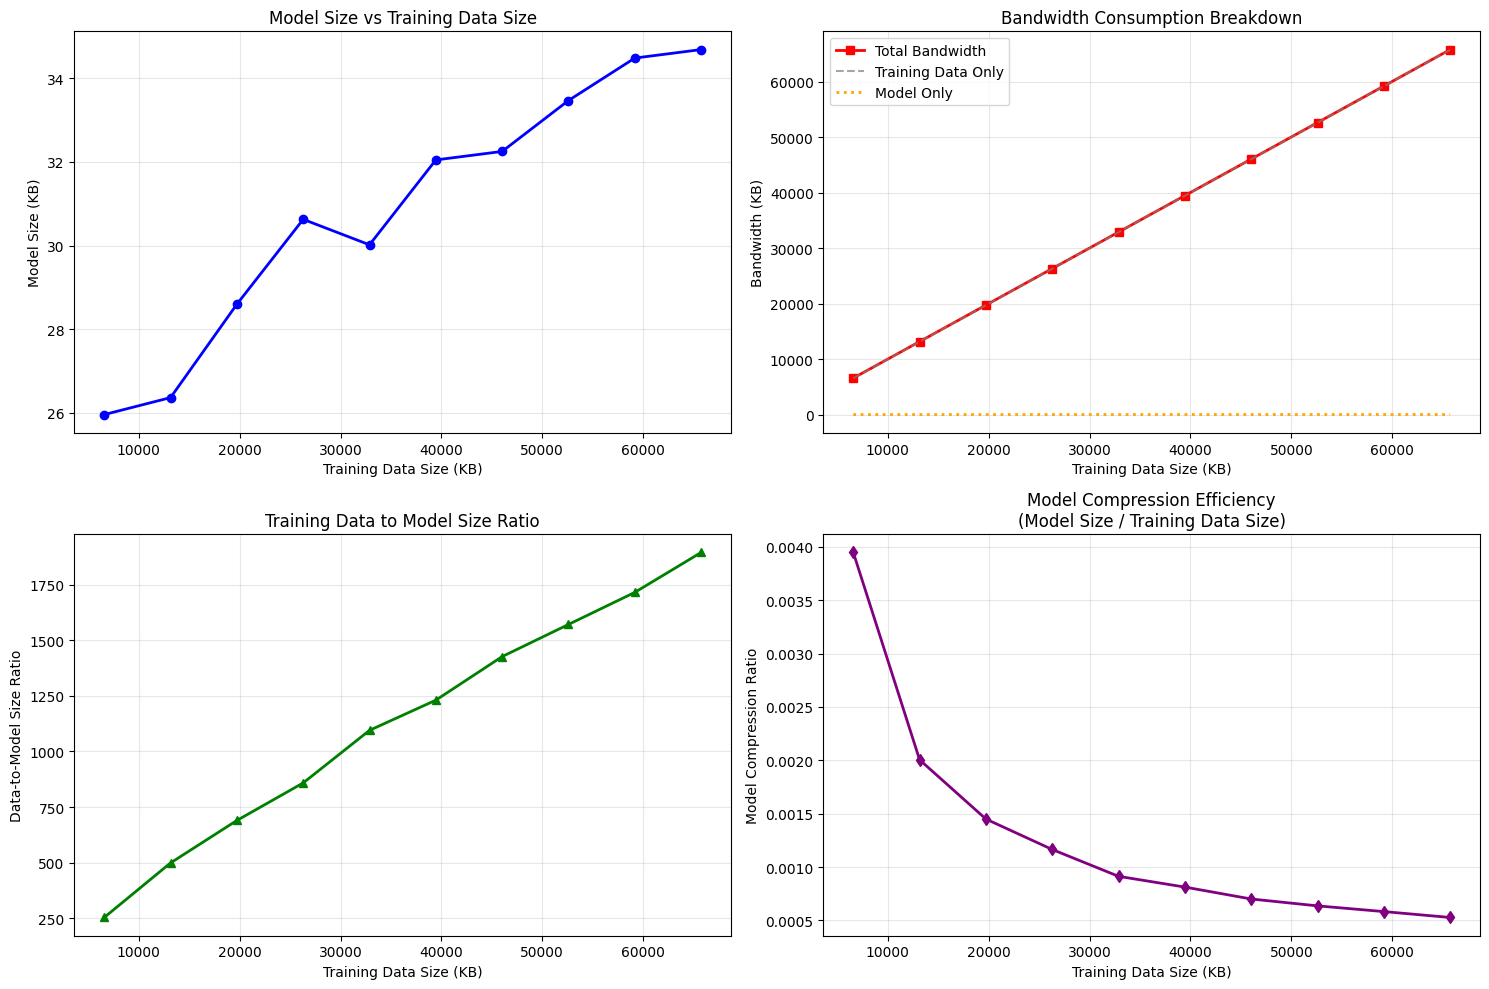

BANDWIDTH CONSUMPTION ANALYSIS
Training data size range: 6574.56 - 65746.16 KB
Model size range: 25.95 - 34.69 KB
Total bandwidth range: 6600.51 - 65780.85 KB
Test data size (constant): 16436.60 KB
Estimated prediction size: 200.37 KB

Efficiency Metrics:
Average data-to-model ratio: 1123.63:1
Average compression ratio: 0.0013
Model size as % of training data: 0.13%

Bandwidth Scenarios (for largest dataset):
Training pipeline: 65780.85 KB
Model deployment: 34.69 KB
Inference pipeline: 16636.97 KB

Estimated Transfer Times (for largest model @ different speeds):
1 Mbps: 0.28 seconds
10 Mbps: 0.03 seconds
100 Mbps: 0.0028 seconds
1 Gbps: 0.000278 seconds


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.tree import DecisionTreeClassifier

# Better helper function to get size in KB
def get_size_kb(obj):
    if hasattr(obj, 'nbytes'):  # NumPy arrays
        return obj.nbytes / 1024
    elif hasattr(obj, 'memory_usage'):  # Pandas DataFrames
        return obj.memory_usage(deep=True).sum() / 1024
    else:  # Fallback to sys.getsizeof
        import sys
        return sys.getsizeof(obj) / 1024

# Store metrics
training_data_sizes_kb = []
model_sizes_kb = []
total_bandwidths_kb = []
data_to_model_ratios = []
compression_ratios = []  # How much smaller the model is compared to training data

# Test data size (constant across all experiments)
test_data_size_kb = get_size_kb(x_test) + get_size_kb(y_test)

# Loop over increasing dataset slices
for i in range(10, 110, 10):  # 10%, 20%, ..., 100%
    slice_size = int(len(x_train) * i / 100)
    x_slice = x_train[:slice_size]
    y_slice = y_train[:slice_size]

    # Calculate training data size in KB (improved calculation)
    training_data_size_kb = get_size_kb(x_slice) + get_size_kb(y_slice)

    # Train model
    model = DecisionTreeClassifier(max_depth=10, random_state=42)
    model.fit(x_slice, y_slice)

    # Save and measure model size
    joblib.dump(model, 'temp_model.joblib')
    model_size_kb = os.path.getsize('temp_model.joblib') / 1024

    # Calculate bandwidth scenarios
    total_bandwidth_kb = training_data_size_kb + model_size_kb
    data_to_model_ratio = training_data_size_kb / model_size_kb if model_size_kb > 0 else 0
    compression_ratio = model_size_kb / training_data_size_kb if training_data_size_kb > 0 else 0

    # Store metrics
    training_data_sizes_kb.append(training_data_size_kb)
    model_sizes_kb.append(model_size_kb)
    total_bandwidths_kb.append(total_bandwidth_kb)
    data_to_model_ratios.append(data_to_model_ratio)
    compression_ratios.append(compression_ratio)

# Clean up temporary file
if os.path.exists('temp_model.joblib'):
    os.remove('temp_model.joblib')

# Create comprehensive bandwidth analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Data vs Model Size
ax1.plot(training_data_sizes_kb, model_sizes_kb, 'o-', color='blue', linewidth=2, markersize=6)
ax1.set_xlabel("Training Data Size (KB)")
ax1.set_ylabel("Model Size (KB)")
ax1.set_title("Model Size vs Training Data Size")
ax1.grid(True, alpha=0.3)

# Plot 2: Total Bandwidth Consumption
ax2.plot(training_data_sizes_kb, total_bandwidths_kb, 's-', color='red', linewidth=2, markersize=6, label='Total Bandwidth')
ax2.plot(training_data_sizes_kb, training_data_sizes_kb, '--', color='gray', alpha=0.7, label='Training Data Only')
ax2.plot(training_data_sizes_kb, model_sizes_kb, ':', color='orange', linewidth=2, label='Model Only')
ax2.set_xlabel("Training Data Size (KB)")
ax2.set_ylabel("Bandwidth (KB)")
ax2.set_title("Bandwidth Consumption Breakdown")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Data-to-Model Size Ratio
ax3.plot(training_data_sizes_kb, data_to_model_ratios, '^-', color='green', linewidth=2, markersize=6)
ax3.set_xlabel("Training Data Size (KB)")
ax3.set_ylabel("Data-to-Model Size Ratio")
ax3.set_title("Training Data to Model Size Ratio")
ax3.grid(True, alpha=0.3)

# Plot 4: Model Compression Ratio
ax4.plot(training_data_sizes_kb, compression_ratios, 'd-', color='purple', linewidth=2, markersize=6)
ax4.set_xlabel("Training Data Size (KB)")
ax4.set_ylabel("Model Compression Ratio")
ax4.set_title("Model Compression Efficiency\n(Model Size / Training Data Size)")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Bandwidth scenarios analysis
print("="*70)
print("BANDWIDTH CONSUMPTION ANALYSIS")
print("="*70)

# Scenario 1: Training pipeline (send data + receive model)
training_pipeline_bandwidth = [data + model for data, model in zip(training_data_sizes_kb, model_sizes_kb)]

# Scenario 2: Model deployment (send model only)
deployment_bandwidth = model_sizes_kb

# Scenario 3: Inference pipeline (send test data + receive predictions)
# Assuming predictions are much smaller than test data (just class labels/probabilities)
prediction_size_kb = len(x_test) * 0.001  # Rough estimate: 1 byte per prediction
inference_bandwidth = [test_data_size_kb + prediction_size_kb] * len(training_data_sizes_kb)

# Summary statistics
print(f"Training data size range: {min(training_data_sizes_kb):.2f} - {max(training_data_sizes_kb):.2f} KB")
print(f"Model size range: {min(model_sizes_kb):.2f} - {max(model_sizes_kb):.2f} KB")
print(f"Total bandwidth range: {min(total_bandwidths_kb):.2f} - {max(total_bandwidths_kb):.2f} KB")
print(f"Test data size (constant): {test_data_size_kb:.2f} KB")
print(f"Estimated prediction size: {prediction_size_kb:.2f} KB")

print(f"\nEfficiency Metrics:")
print(f"Average data-to-model ratio: {np.mean(data_to_model_ratios):.2f}:1")
print(f"Average compression ratio: {np.mean(compression_ratios):.4f}")
print(f"Model size as % of training data: {np.mean(compression_ratios)*100:.2f}%")

print(f"\nBandwidth Scenarios (for largest dataset):")
print(f"Training pipeline: {max(training_pipeline_bandwidth):.2f} KB")
print(f"Model deployment: {max(deployment_bandwidth):.2f} KB")
print(f"Inference pipeline: {inference_bandwidth[0]:.2f} KB")

# Network transfer time estimates (for reference)
print(f"\nEstimated Transfer Times (for largest model @ different speeds):")
max_model_kb = max(model_sizes_kb)
print(f"1 Mbps: {(max_model_kb * 8 / 1000):.2f} seconds")
print(f"10 Mbps: {(max_model_kb * 8 / 10000):.2f} seconds")
print(f"100 Mbps: {(max_model_kb * 8 / 100000):.4f} seconds")
print(f"1 Gbps: {(max_model_kb * 8 / 1000000):.6f} seconds")

In [25]:
def get_system_specs():
    """Display comprehensive system specifications"""
    
    print("="*70)
    print(" SYSTEM SPECIFICATIONS")
    print("="*70)
    
    # Basic System Information
    print(f"System: {platform.system()}")
    print(f"Node Name: {platform.node()}")
    print(f"Release: {platform.release()}")
    print(f"Version: {platform.version()}")
    print(f"Machine: {platform.machine()}")
    print(f"Processor: {platform.processor()}")
    print(f"Architecture: {platform.architecture()[0]} ({platform.architecture()[1]})")
    
    print("\n" + "-"*50)
    print(" PYTHON ENVIRONMENT")
    print("-"*50)
    print(f"Python Version: {sys.version}")
    print(f"Python Implementation: {platform.python_implementation()}")
    print(f"Python Compiler: {platform.python_compiler()}")
    
    print("\n" + "-"*50)
    print(" CPU INFORMATION")
    print("-"*50)
    print(f"Physical Cores: {psutil.cpu_count(logical=False)}")
    print(f"Total Cores: {psutil.cpu_count(logical=True)}")
    
    # CPU frequency
    try:
        cpufreq = psutil.cpu_freq()
        print(f"Max Frequency: {cpufreq.max:.2f} MHz")
        print(f"Min Frequency: {cpufreq.min:.2f} MHz")
        print(f"Current Frequency: {cpufreq.current:.2f} MHz")
    except:
        print("CPU Frequency: Not available")
    
    # CPU usage
    print(f"CPU Usage Per Core:")
    for i, percentage in enumerate(psutil.cpu_percent(percpu=True, interval=1)):
        print(f"  Core {i}: {percentage}%")
    print(f"Total CPU Usage: {psutil.cpu_percent(interval=1)}%")
    
    print("\n" + "-"*50)
    print(" MEMORY INFORMATION")
    print("-"*50)
    
    # RAM
    svmem = psutil.virtual_memory()
    print(f"Total RAM: {get_size(svmem.total)}")
    print(f"Available RAM: {get_size(svmem.available)}")
    print(f"Used RAM: {get_size(svmem.used)}")
    print(f"RAM Usage: {svmem.percent}%")
    
    # Swap
    swap = psutil.swap_memory()
    print(f"Total Swap: {get_size(swap.total)}")
    print(f"Free Swap: {get_size(swap.free)}")
    print(f"Used Swap: {get_size(swap.used)}")
    print(f"Swap Usage: {swap.percent}%")
    
    print("\n" + "-"*50)
    print(" DISK INFORMATION")
    print("-"*50)
    
    # Disk usage
    partitions = psutil.disk_partitions()
    for partition in partitions:
        print(f"Device: {partition.device}")
        print(f"  Mountpoint: {partition.mountpoint}")
        print(f"  File System: {partition.fstype}")
        try:
            partition_usage = psutil.disk_usage(partition.mountpoint)
            print(f"  Total Size: {get_size(partition_usage.total)}")
            print(f"  Used: {get_size(partition_usage.used)}")
            print(f"  Free: {get_size(partition_usage.free)}")
            print(f"  Usage: {partition_usage.percent}%")
        except PermissionError:
            print("  Permission Denied")
        print()
    
    print("-"*50)
    print(" NETWORK INFORMATION")
    print("-"*50)
    
    # Network interfaces
    if_addrs = psutil.net_if_addrs()
    for interface_name, interface_addresses in if_addrs.items():
        for address in interface_addresses:
            print(f"Interface: {interface_name}")
            if str(address.family) == 'AddressFamily.AF_INET':
                print(f"  IP Address: {address.address}")
                print(f"  Netmask: {address.netmask}")
                print(f"  Broadcast IP: {address.broadcast}")
            elif str(address.family) == 'AddressFamily.AF_PACKET':
                print(f"  MAC Address: {address.address}")
                print(f"  Netmask: {address.netmask}")
                print(f"  Broadcast MAC: {address.broadcast}")
        print()
    
    # Network statistics
    net_io = psutil.net_io_counters()
    print(f"Total Bytes Sent: {get_size(net_io.bytes_sent)}")
    print(f"Total Bytes Received: {get_size(net_io.bytes_recv)}")
    
    print("\n" + "-"*50)
    print(" ADDITIONAL INFORMATION")
    print("-"*50)
    
    # Boot time
    boot_time_timestamp = psutil.boot_time()
    bt = datetime.fromtimestamp(boot_time_timestamp)
    print(f"Boot Time: {bt.year}/{bt.month}/{bt.day} {bt.hour}:{bt.minute}:{bt.second}")
    
    # Current time
    print(f"Current Time: {datetime.now().strftime('%Y/%m/%d %H:%M:%S')}")
    
    # Environment variables of interest
    print(f"Home Directory: {os.path.expanduser('~')}")
    print(f"Current Working Directory: {os.getcwd()}")
    
    # Check for GPU (if available)
    try:
        import GPUtil
        gpus = GPUtil.getGPUs()
        if gpus:
            print("\n" + "-"*50)
            print(" GPU INFORMATION")
            print("-"*50)
            for i, gpu in enumerate(gpus):
                print(f"GPU {i}: {gpu.name}")
                print(f"  Memory Total: {gpu.memoryTotal}MB")
                print(f"  Memory Free: {gpu.memoryFree}MB")
                print(f"  Memory Used: {gpu.memoryUsed}MB")
                print(f"  Temperature: {gpu.temperature}°C")
                print(f"  GPU Load: {gpu.load*100:.1f}%")
        else:
            print("\nNo GPU detected")
    except ImportError:
        print("\nGPU information not available (install GPUtil for GPU stats)")
    
    print("\n" + "="*70)

def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor


get_system_specs()

 SYSTEM SPECIFICATIONS
System: Windows
Node Name: DESKTOP-7I3OMQB
Release: 11
Version: 10.0.22631
Machine: AMD64
Processor: Intel64 Family 6 Model 186 Stepping 2, GenuineIntel
Architecture: 64bit (WindowsPE)

--------------------------------------------------
 PYTHON ENVIRONMENT
--------------------------------------------------
Python Version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
Python Implementation: CPython
Python Compiler: MSC v.1940 64 bit (AMD64)

--------------------------------------------------
 CPU INFORMATION
--------------------------------------------------
Physical Cores: 14
Total Cores: 20
Max Frequency: 2400.00 MHz
Min Frequency: 0.00 MHz
Current Frequency: 2400.00 MHz
CPU Usage Per Core:
  Core 0: 42.9%
  Core 1: 1.6%
  Core 2: 1.6%
  Core 3: 4.7%
  Core 4: 21.9%
  Core 5: 0.0%
  Core 6: 6.2%
  Core 7: 4.8%
  Core 8: 0.0%
  Core 9: 3.1%
  Core 10: 3.1%
  Core 11: 3.1%
  Core 12: 9.4%
  Core 13: 20.3%
  Core 14: 1.6%
  Core 1